# Introduction

A common question is "why do we need to have both a validation set _and_ a test set in machine learning?". 

Here's a quick illustration of what can go wrong if you do model-selection based on test set performance. 

We'll generate some completely random binary classification data, with the same number of instances in each class. Meaning that it's not possible to create a model that can perform better than 50-50 on new data. 

Then we'll see how easy it is to get a model that performs better than 50-50 on the test set ***if we choose the model based on its test set performance***, and how having a validation set for the model selection step avoids this issue. 

# Setup

In [1]:
%matplotlib inline

import numpy as np, matplotlib.pyplot as plt

In [2]:
np.random.seed(3)

# Create the data set

We'll make a random data set with 1000 instances, five features (that have random values between 0 and 1) and two two classes with 500 instances in each one. 

To better see what's going on, here's a smaller version:

In [3]:
X_sample = np.random.rand(10, 5)
y_sample = np.append(np.ones((1,5), dtype=int), np.zeros((1,5), dtype=int))

Here's the data:

In [4]:
X_sample

array([[0.5507979 , 0.70814782, 0.29090474, 0.51082761, 0.89294695],
       [0.89629309, 0.12558531, 0.20724288, 0.0514672 , 0.44080984],
       [0.02987621, 0.45683322, 0.64914405, 0.27848728, 0.6762549 ],
       [0.59086282, 0.02398188, 0.55885409, 0.25925245, 0.4151012 ],
       [0.28352508, 0.69313792, 0.44045372, 0.15686774, 0.54464902],
       [0.78031476, 0.30636353, 0.22195788, 0.38797126, 0.93638365],
       [0.97599542, 0.67238368, 0.90283411, 0.84575087, 0.37799404],
       [0.09221701, 0.6534109 , 0.55784076, 0.36156476, 0.2250545 ],
       [0.40651992, 0.46894025, 0.26923558, 0.29179277, 0.4576864 ],
       [0.86053391, 0.5862529 , 0.28348786, 0.27797751, 0.45462208]])

Here are the labels:

In [5]:
y_sample

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

The bigger data set:

In [6]:
X = np.random.rand(1000, 5)
y = np.append(np.ones((1,500), dtype=int), np.zeros((1,500), dtype=int))

500 samples belonging to class 0, 500 to class 1. Random feature values in all the 5 features. 

> It is completely futile to create a predictive model that can in any way make a better-than-chance classification using this data set. We proceed. 

# Prepare data for ML

We split off a test set using stratified splitting:

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

We see that we've kept the class balanced also in the training and test set. 

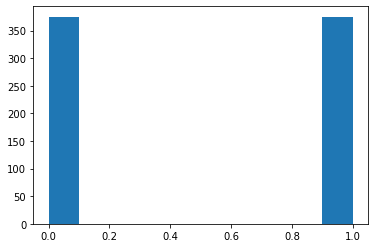

In [9]:
plt.hist(y_train)
plt.show()

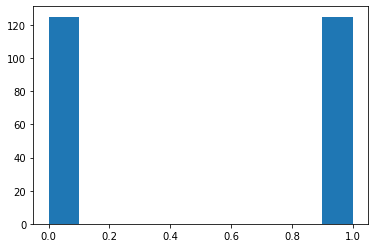

In [10]:
plt.hist(y_test)
plt.show()

This means that the expected performance is still 50-50 on the test set. 

# Modelling

We'll create a bunch of slightly different random forest models by varying the random states. You should think of this as an example of the more general process of model selection where one tries out many different models (and model ensembles).

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
nb_models = 200

models = [RandomForestClassifier(random_state=seed, n_jobs=-1) for seed in range(nb_models)]

In [14]:
best_accuracy = 0.

for i in range(nb_models):
    model = models[i]
    model.fit(X_train, y_train)
    acc = model.score(X_test, y_test)
    if acc > best_accuracy:
        best_accuracy = acc
        print(f"The current best model is number {i},")
        print(f"which has an accuracy of {acc} on the test set\n")
        print("#"*40)

The current best model is number 0,
which has an accuracy of 0.508 on the test set

########################################
The current best model is number 2,
which has an accuracy of 0.536 on the test set

########################################
The current best model is number 17,
which has an accuracy of 0.56 on the test set

########################################


That's a pretty good accuracy, considering that the data set is random!

# What if we had a validation set?

Let's create a validation set in addition to the training and test sets we already have. 

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, random_state=42)

In [16]:
len(X_train), len(X_val)

(562, 188)

Let's then use the more appropriate way to select among the models we're training: namely using the validation set performance:

In [18]:
models = [RandomForestClassifier(random_state=seed, n_jobs=-1) for seed in range(nb_models)]

In [19]:
best_val_accuracy = 0.
best_model = None

for i in range(nb_models):
    model = models[i]
    model.fit(X_train, y_train)
    acc = model.score(X_val, y_val)
    if acc > best_val_accuracy:
        best_model = model
        best_val_accuracy = acc
        print(f"The current best model is number {i},")
        print(f"which has an accuracy of {acc} on the validation set\n")
        print("#"*40)

The current best model is number 0,
which has an accuracy of 0.5425531914893617 on the validation set

########################################
The current best model is number 11,
which has an accuracy of 0.5531914893617021 on the validation set

########################################
The current best model is number 18,
which has an accuracy of 0.574468085106383 on the validation set

########################################


The best model has a score of ~57% on the validation set. Better than chance?!

But let's see how it performs on the test set:

In [20]:
best_model.score(X_test, y_test)

0.508

Still random. 

What's going on? Since we try out a bunch of models on the validation data set, some can, by chance, seem to be able to make better-than-chance predictions. And we are led to pick that model. But in a correct machine learning setup one wouldn't stop there and report the validation accuracy as the final performance estimate! Realising the possibility of _overfitting_ to the validation data, one would have a separate test set used to estimate the actual generalization performance of the model. As we see in the above simulation, that's a good idea. The "best model" as measured by the validation performance is still no good.  